# Training MNet

In [33]:
import numpy as np
from keras import backend as K
import scipy
from skimage.measure import label, regionprops
import os
from keras.preprocessing import image
import tensorflow as tf
from keras.optimizers import SGD
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,
    Activation, Conv2DTranspose, Multiply, Add, AveragePooling2D, Average
)
from keras.models import Model
import random
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Utils

In [34]:
# Define helper functions
def mk_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

def return_list(data_path, data_type):
    file_list = [file for file in os.listdir(data_path) if file.lower().endswith(data_type)]
    print(str(len(file_list)))
    return file_list

def train_loader(data_list, data_path, mask_path, input_size):
    for lineIdx in range(len(data_list)):
        temp_txt = data_list[lineIdx]

        train_img = np.asarray(image.load_img(
            os.path.join(data_path, temp_txt),
            target_size=(input_size, input_size, 3))
        ).astype('float32')

        img_mask = np.asarray(image.load_img(
            os.path.join(mask_path, temp_txt),
            target_size=(input_size, input_size, 3))) / 255.0

        img_mask = img_mask.astype('float32')

        yield (train_img, (img_mask, img_mask, img_mask, img_mask, img_mask))


def tf_data_loader(data_list, data_path, mask_path, input_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: train_loader(data_list, data_path, mask_path, input_size),
        output_signature=(
            tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32),
            tuple([tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32)] * 5)
        )
    )
    return dataset

In [35]:
# Training Settings
result_path = mk_dir('/kaggle/working/output_deep_model/')
#pre_model_file = '/kaggle/input/deep-model/deep_model/Model_MNet_REFUGE.h5'
save_model_file = os.path.join(result_path, 'Model_MNet_REFUGE_v2.keras')

root_path = '/kaggle/input/training-data-polar/training_crop/'
train_data_path = root_path + 'data/'
train_mask_path = root_path + 'label/'

val_data_path = root_path + 'val_data/data/'
val_mask_path = root_path + 'val_data/label/'

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

1400
300


## Model MNet

In [36]:
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,
    Activation, Conv2DTranspose, Multiply, Add, AveragePooling2D, Average
)
from keras.models import Model
import tensorflow as tf

def residual_block(x, filters, block_name):
    """
    A residual block with two convolutional layers and a skip connection.

    Parameters:
    - x: Input tensor.
    - filters: Number of filters for the convolutional layers.
    - block_name: Base name for the layers in this block.

    Returns:
    - Output tensor after applying the residual block.
    """
    # First convolutional layer
    conv = Conv2D(filters, (3, 3), padding='same', name=f'{block_name}_conv1')(x)
    conv = BatchNormalization(name=f'{block_name}_bn1')(conv)
    conv = Activation('relu', name=f'{block_name}_relu1')(conv)

    # Second convolutional layer
    conv = Conv2D(filters, (3, 3), padding='same', name=f'{block_name}_conv2')(conv)
    conv = BatchNormalization(name=f'{block_name}_bn2')(conv)

    # Shortcut connection
    shortcut = Conv2D(filters, (1, 1), padding='same', name=f'{block_name}_shortcut')(x)
    shortcut = BatchNormalization(name=f'{block_name}_shortcut_bn')(shortcut)

    # Adding the shortcut to the main path
    out = Add(name=f'{block_name}_add')([conv, shortcut])
    out = Activation('relu', name=f'{block_name}_relu2')(out)
    return out

def attention_gate(x, g, inter_channels, name_prefix):
    """
    Attention Gate with unique naming.

    Parameters:
    - x: Input feature map from the encoder (skip connection).
    - g: Gating signal from the decoder.
    - inter_channels: Number of filters for intermediate computations.
    - name_prefix: Unique prefix for naming the layers.

    Returns:
    - Attention-weighted feature map.
    """
    theta_x = Conv2D(inter_channels, (2, 2), strides=(2, 2), padding='same', name=f'{name_prefix}_theta_x')(x)
    phi_g = Conv2D(inter_channels, (1, 1), padding='same', name=f'{name_prefix}_phi_g')(g)
    add = Add(name=f'{name_prefix}_add')([theta_x, phi_g])
    relu = Activation('relu', name=f'{name_prefix}_relu')(add)
    psi = Conv2D(1, (1, 1), padding='same', name=f'{name_prefix}_psi')(relu)
    sigmoid = Activation('sigmoid', name=f'{name_prefix}_sigmoid')(psi)
    upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear', name=f'{name_prefix}_upsample')(sigmoid)
    attn_coefficients = Multiply(name=f'{name_prefix}_multiply')([x, upsampled])
    return attn_coefficients

def DeepModel(size_set=800):
    """
    Builds the deep learning model with residual connections and uniquely named attention gates.

    Parameters:
    - size_set: The height and width of the input images.

    Returns:
    - A Keras Model instance.
    """
    img_input = Input(shape=(size_set, size_set, 3), name='input_image')

    # Scaled inputs
    scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='scale_img_2')(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='scale_img_3')(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='scale_img_4')(scale_img_3)

    # Block 1 with Residual Connections
    conv1 = residual_block(img_input, 32, 'block1')
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    # Block 2 with Residual Connections
    input2 = Conv2D(64, (3, 3), padding='same', name='block2_input1')(scale_img_2)
    input2 = BatchNormalization(name='block2_input1_bn')(input2)
    input2 = Activation('relu', name='block2_input1_relu')(input2)
    input2 = concatenate([input2, pool1], axis=3, name='block2_concat')
    conv2 = residual_block(input2, 64, 'block2')
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

    # Block 3 with Residual Connections
    input3 = Conv2D(128, (3, 3), padding='same', name='block3_input1')(scale_img_3)
    input3 = BatchNormalization(name='block3_input1_bn')(input3)
    input3 = Activation('relu', name='block3_input1_relu')(input3)
    input3 = concatenate([input3, pool2], axis=3, name='block3_concat')
    conv3 = residual_block(input3, 128, 'block3')
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    # Block 4 with Residual Connections
    input4 = Conv2D(256, (3, 3), padding='same', name='block4_input1')(scale_img_4)
    input4 = BatchNormalization(name='block4_input1_bn')(input4)
    input4 = Activation('relu', name='block4_input1_relu')(input4)
    input4 = concatenate([input4, pool3], axis=3, name='block4_concat')
    conv4 = residual_block(input4, 256, 'block4')
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

    # Bridge with Residual Connections
    conv5 = residual_block(pool4, 512, 'block5')

    # Decoder with Attention Gates and Residual Connections

    # Up Block 6
    attn4 = attention_gate(conv4, conv5, inter_channels=256, name_prefix='attn4')
    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5)
    up6 = concatenate([up6, attn4], axis=3, name='block6_concat')
    conv6 = residual_block(up6, 256, 'block6')

    # Up Block 7
    attn3 = attention_gate(conv3, conv6, inter_channels=128, name_prefix='attn3')
    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6)
    up7 = concatenate([up7, attn3], axis=3, name='block7_concat')
    conv7 = residual_block(up7, 128, 'block7')

    # Up Block 8
    attn2 = attention_gate(conv2, conv7, inter_channels=64, name_prefix='attn2')
    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7)
    up8 = concatenate([up8, attn2], axis=3, name='block8_concat')
    conv8 = residual_block(up8, 64, 'block8')

    # Up Block 9
    attn1 = attention_gate(conv1, conv8, inter_channels=32, name_prefix='attn1')
    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8)
    up9 = concatenate([up9, attn1], axis=3, name='block9_concat')
    conv9 = residual_block(up9, 32, 'block9')

    # Side Outputs with 1 channel each
    side6 = UpSampling2D(size=(8, 8), name='side6_upsample')(conv6)
    side7 = UpSampling2D(size=(4, 4), name='side7_upsample')(conv7)
    side8 = UpSampling2D(size=(2, 2), name='side8_upsample')(conv8)
    out6 = Conv2D(3, (1, 1), activation='softmax', name='side_63')(side6)
    out7 = Conv2D(3, (1, 1), activation='softmax', name='side_73')(side7)
    out8 = Conv2D(3, (1, 1), activation='softmax', name='side_83')(side8)
    out9 = Conv2D(3, (1, 1), activation='softmax', name='side_93')(conv9)
    
    # Final Output with name 'final_output'
    out10 = Average(name='final_output')([out6, out7, out8, out9])

    # Define the model
    model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9, out10], name='DeepModel_with_Residuals')

    return model

# Training 

In [37]:
# # Set the root and data paths
# root_path = '/kaggle/input/training-data-polar/training_crop/'
# train_data_path = os.path.join(root_path, 'data/')
# train_mask_path = os.path.join(root_path, 'label/')

# val_data_path = os.path.join(root_path, 'val_data/data/')
# val_mask_path = os.path.join(root_path, 'val_data/label/')

# # Define image dimensions
# IMAGE_SIZE = 800  # As per your model's input size

# # Function to load and preprocess images
# def load_image(path, target_size):
#     img = load_img(path, target_size=(target_size, target_size))
#     img = img_to_array(img)
#     img = img / 255.0  # Normalize to [0, 1]
#     return img

# # Function to load and preprocess masks
# def load_mask(path, target_size):
#     mask = load_img(path, target_size=(target_size, target_size), color_mode='grayscale')
#     mask = img_to_array(mask)
#     mask = mask / 255.0  # Normalize to [0, 1]
#     mask = np.round(mask)  # Ensure binary masks
#     return mask

# # Custom data generator
# class DataGenerator(Sequence):
#     def __init__(self, image_filenames, mask_filenames, image_dir, mask_dir, batch_size, target_size, shuffle=True):
#         self.image_filenames = image_filenames
#         self.mask_filenames = mask_filenames
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.batch_size = batch_size
#         self.target_size = target_size
#         self.shuffle = shuffle
#         self.on_epoch_end()
    
#     def __len__(self):
#         return int(np.ceil(len(self.image_filenames) / self.batch_size))
    
#     def __getitem__(self, index):
#         # Generate indexes of the batch
#         batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
#         # Find list of IDs
#         batch_image_filenames = [self.image_filenames[k] for k in batch_indexes]
#         batch_mask_filenames = [self.mask_filenames[k] for k in batch_indexes]
        
#         # Generate data
#         X, Y = self.__data_generation(batch_image_filenames, batch_mask_filenames)
        
#         return X, Y
    
#     def on_epoch_end(self):
#         self.indexes = np.arange(len(self.image_filenames))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)
    
#     def __data_generation(self, batch_image_filenames, batch_mask_filenames):
#         X = np.empty((len(batch_image_filenames), self.target_size, self.target_size, 3), dtype=np.float32)
#         Y = np.empty((len(batch_mask_filenames), self.target_size, self.target_size, 1), dtype=np.float32)
        
#         for i, (img_name, mask_name) in enumerate(zip(batch_image_filenames, batch_mask_filenames)):
#             img_path = os.path.join(self.image_dir, img_name)
#             mask_path = os.path.join(self.mask_dir, mask_name)
            
#             # Load and preprocess images and masks
#             img = load_image(img_path, self.target_size)
#             mask = load_mask(mask_path, self.target_size)
            
#             X[i] = img
#             Y[i] = mask
        
#         # Prepare outputs as a dictionary mapping output names to targets
#         Y_multi = {
#             'side_63': Y,
#             'side_73': Y,
#             'side_83': Y,
#             'side_93': Y,
#             'final_output': Y
#         }
#         return X, Y_multi


# # Get the list of image and mask filenames for training
# train_image_files = sorted(os.listdir(train_data_path))
# train_mask_files = sorted(os.listdir(train_mask_path))

# # Get the list of image and mask filenames for validation
# val_image_files = sorted(os.listdir(val_data_path))
# val_mask_files = sorted(os.listdir(val_mask_path))

# # Create data generators
# batch_size = 4  # Adjust based on your GPU memory

# train_generator = DataGenerator(
#     train_image_files, train_mask_files,
#     train_data_path, train_mask_path,
#     batch_size=batch_size, target_size=IMAGE_SIZE, shuffle=True
# )

# val_generator = DataGenerator(
#     val_image_files, val_mask_files,
#     val_data_path, val_mask_path,
#     batch_size=batch_size, target_size=IMAGE_SIZE, shuffle=False
# )

# # Define the model
# model = DeepModel(size_set=IMAGE_SIZE)

# # Compile the model with dictionaries for losses and loss_weights
# losses = {
#     'side_63': 'binary_crossentropy',
#     'side_73': 'binary_crossentropy',
#     'side_83': 'binary_crossentropy',
#     'side_93': 'binary_crossentropy',
#     'final_output': 'binary_crossentropy'
# }

# loss_weights = {
#     'side_63': 0.1,
#     'side_73': 0.1,
#     'side_83': 0.1,
#     'side_93': 0.1,
#     'final_output': 0.6
# }

# def dice_coefficient(y_true, y_pred):
#     smooth = 1.  # Avoid division by zero
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# metrics = {
#     'side_63': ['accuracy'],
#     'side_73': ['accuracy'],
#     'side_83': ['accuracy'],
#     'side_93': ['accuracy'],
#     'final_output': ['accuracy']#, dice_coefficie
# }

# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss=losses,
#     loss_weights=loss_weights,
#     metrics= metrics,
# )

# # Callbacks
# checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.weights.h5',
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True,
#     mode='min',
#     save_weights_only=True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     min_lr=1e-7,
#     verbose=1
# )

# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

# callbacks_list = [checkpoint, reduce_lr, early_stopping]

# # Train the model
# epochs = 50  # Adjust as needed
# print("Start training")
# model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

In [38]:
# Define the Dice Loss function
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for multiclass segmentation.
    """
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice_score = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - tf.reduce_mean(dice_score)

In [39]:
# Total_iter = 50
# nb_epoch_setting = 10
# input_size = 224
# #optimizer_setting = SGD(learning_rate=0.0001, momentum=0.9)
# optimizer_setting = Adam(learning_rate=0.0001, use_ema = True)

# # Build and compile the model
# my_model = DeepModel(size_set=input_size)
# # my_model.load_weights(pre_model_file, by_name=True)

# my_model.compile(optimizer=optimizer_setting, loss='categorical_crossentropy',
#                  loss_weights=[0.1, 0.1, 0.1, 0.1, 0.6])

# print(my_model.input_shape)  # Should output (None, 400, 400, 3)

# # Data Preparation
# train_dataset = tf_data_loader(train_list, train_data_path, train_mask_path, input_size)
# val_dataset = tf_data_loader(val_list, val_data_path, val_mask_path, input_size)

# train_dataset = train_dataset.shuffle(buffer_size=len(train_list)).batch(4).repeat().prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.batch(4).repeat().prefetch(tf.data.AUTOTUNE)

# batch_size = 4
# steps_per_epoch = len(train_list) // batch_size
# validation_steps = len(val_list) // batch_size

# # Verify data shapes
# for images, labels in train_dataset.take(1):
#     print("Image shape:", images.shape)  # Expected: (batch_size, input_size, input_size, 3)
#     for idx, label in enumerate(labels):
#         print(f"Label {idx+1} shape:", label.shape)  # Expected: (batch_size, input_size, input_size, 3)

# # Training Loop
# loss_max = 10000
# for idx_iter in range(Total_iter):
#     print("Training started")
#     model_return = my_model.fit(
#         x=train_dataset,
#         validation_data=val_dataset,
#         epochs=nb_epoch_setting,
#         steps_per_epoch=steps_per_epoch,
#         validation_steps=validation_steps,
#         verbose=1
#     )
#     val_loss = model_return.history['val_loss'][0]
#     train_loss = model_return.history['loss'][0]
#     if val_loss < loss_max:
#         my_model.save(save_model_file)
#         loss_max = val_loss
#         print('[Save] training iter: ' + str(idx_iter+1) +
#               ', train_loss: ' + str(train_loss) +
#               ', val_loss: ' + str(val_loss))
#     else:
#         print('[None] training iter: ' + str(idx_iter+1) +
#               ', train_loss: ' + str(train_loss) +
#               ', val_loss: ' + str(val_loss))

In [41]:
input_size = 224
batch_size = 8
epochs = 100  # Total number of epochs to train

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

# Create TensorFlow datasets
train_dataset = tf_data_loader(train_list, train_data_path, train_mask_path, input_size)
val_dataset = tf_data_loader(val_list, val_data_path, val_mask_path, input_size)

# Calculate steps per epoch
steps_per_epoch = len(train_list) // batch_size
validation_steps = len(val_list) // batch_size

# Prepare the datasets
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(train_list), reshuffle_each_iteration=True)
    .batch(batch_size)
    .repeat()  # Repeat indefinitely
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# Initialize the model
my_model = DeepModel(size_set=input_size)

# Define the optimizer
optimizer_setting = SGD(learning_rate=0.0001, momentum=0.9)

# Compile the model
my_model.compile(
    optimizer=optimizer_setting,
    loss=dice_loss,
    loss_weights=[0.1, 0.1, 0.1, 0.1, 0.6]
)

# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint(
    filepath=save_model_file,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

# Train the model
history = my_model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

1400
300
Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.7545
Epoch 1: val_loss improved from inf to 0.71425, saving model to /kaggle/working/output_deep_model/Model_MNet_REFUGE_v2.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 93s 289ms/step - loss: 0.7545 - val_loss: 0.7142
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.7152
Epoch 2: val_loss improved from 0.71425 to 0.69425, saving model to /kaggle/working/output_deep_model/Model_MNet_REFUGE_v2.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 57s 248ms/step - loss: 0.7151 - val_loss: 0.6943
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.6843
Epoch 3: val_loss improved from 0.69425 to 0.65744, saving model to /kaggle/working/output_deep_model/Model_MNet_REFUGE_v2.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 269ms/step - loss: 0.6842 - val_loss: 0.6574
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.6602
Epoch 4: val_loss improved from 0.65744 to 0.65469, saving model to /kaggle/working/output_dee

## Validation try

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


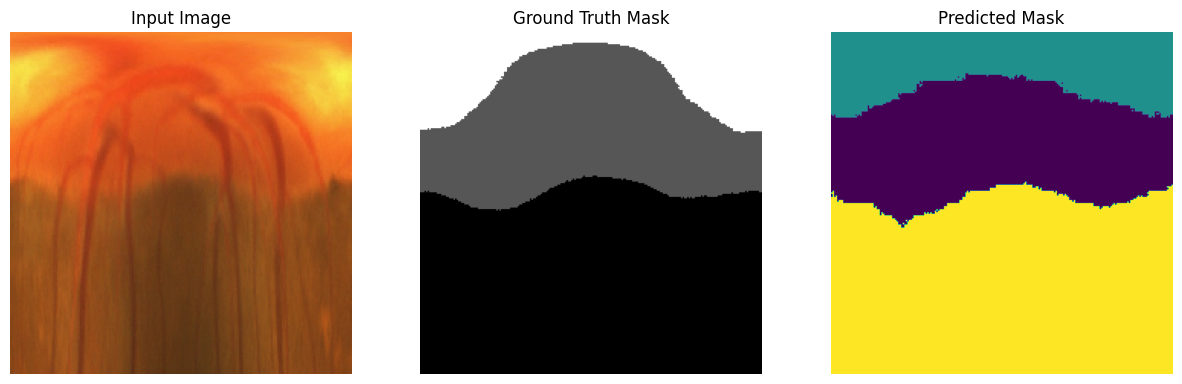

In [47]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
# Function to load a single image and mask
def load_single_image(img_path, mask_path, target_size):
    # Load and preprocess the image
    img = np.asarray(image.load_img(
        img_path,
        target_size=(target_size, target_size, 3))
    ).astype('float32')
    
    # Load and preprocess the mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size),
        color_mode='grayscale')
    
    img_mask = np.asarray(img_mask).astype('int32')
    
    return img, img_mask

# Select a sample from the validation set
sample_index = 0
sample_img_name = val_list[sample_index]
sample_mask_name = val_list[sample_index]  # Assuming mask filenames are the same as image filenames

sample_img_path = os.path.join(val_data_path, sample_img_name)
sample_mask_path = os.path.join(val_mask_path, sample_mask_name)

# Load the image and mask
input_size = 224  # Ensure this matches your model's expected input size
img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
predictions = my_model.predict(img_input)
final_output = predictions[-1][0]  # Extract the first sample from the batch

# Since the model outputs softmax probabilities over 3 classes, take the argmax to get predicted class labels
predicted_mask = np.argmax(final_output, axis=-1)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img/255.0)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()